## Feature Selection must include:
- Removal of unnecessary variables such as ID
- Removal of correlated variables
- Removal of variables with low predictive power

In [48]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# to build the models
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

# for feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score

In [2]:
X_train = pd.read_csv('xtrain.csv')
X_test = pd.read_csv('xtest.csv')

X_train.head()

,Defaulted,Amount,ApplicationSignedHour,ApplicationSignedWeekday,City,Country,DateOfBirth,DebtToIncome,Education,EmploymentDurationCurrentEmployer,EmploymentPosition,EmploymentStatus,ExistingLiabilities,Gender,HomeOwnershipType,IncomeFromPrincipalEmployer,IncomeTotal,Interest rate (APR),LoanDate,LoanDuration,MaritalStatus,NewCreditCustomer,NoOfPreviousLoansBeforeLoan,OccupationArea,UseOfLoan,VerificationType,WorkExperience,PreviousScore,City_na,EmploymentDurationCurrentEmployer_na,EmploymentPosition_na,WorkExperience_na,DebtToIncome_na,Education_na,EmploymentStatus_na,Gender_na,HomeOwnershipType_na,MaritalStatus_na,OccupationArea_na,VerificationType_na,PreviousScore_na
0,1,0.234263,0.695652,0.500000,0.5,0.000000,0.6750,0.145198,0.50,0.666667,0.142857,0.25,0.055556,0.5,0.111111,0.000000,0.012624,0.149441,0.636364,0.593220,0.50,1.0,0.0,0.45,0.054545,1.000000,0.4,0.281769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.238501,1.000000,0.000000,0.5,0.333333,0.4125,0.075163,0.75,0.333333,0.714286,0.25,0.027778,0.0,0.777778,0.014180,0.014180,0.109500,0.454545,1.000000,0.00,1.0,0.0,0.10,0.027273,0.666667,0.0,0.158786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.102402,0.652174,0.333333,0.5,0.000000,0.5750,0.344172,1.00,1.000000,0.857143,0.25,0.277778,0.5,0.333333,0.006466,0.008414,0.108263,0.636364,0.186441,0.25,1.0,0.0,0.85,0.000000,1.000000,0.8,0.434872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.799383,0.869565,0.333333,0.2,0.000000,0.7125,0.231616,0.75,0.500000,0.571429,0.25,0.027778,0.5,0.333333,0.013534,0.013534,0.118316,0.363636,1.000000,0.25,1.0,0.0,0.70,0.063636,0.000000,0.6,0.201637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.279943,0.695652,0.000000,0.5,0.000000,0.5000,0.394822,0.75,0.666667,0.714286,0.25,0.055556,0.5,0.111111,0.006015,0.006015,0.112555,0.000000,1.000000,0.00,1.0,0.0,0.10,0.018182,0.000000,0.6,0.340646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# capture the target
y_train = X_train['Defaulted']
y_test = X_test['Defaulted']

# drop unnecessary variables from our training and testing sets
X_train.drop(['Defaulted'], axis=1, inplace=True)
X_test.drop(['Defaulted'], axis=1, inplace=True)

### Remove correlated features

In [46]:
def correlationHeatmap(df):
    df = df.copy()
    _ , ax = plt.subplots(figsize =(10, 8))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(df.corr(), cmap = colormap, square=True, cbar_kws={'shrink':.9 }, ax=ax, 
                    fmt='.2f', annot=True, linewidths=0.1,vmax=1.0, linecolor='white', annot_kws={'fontsize':9 })

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

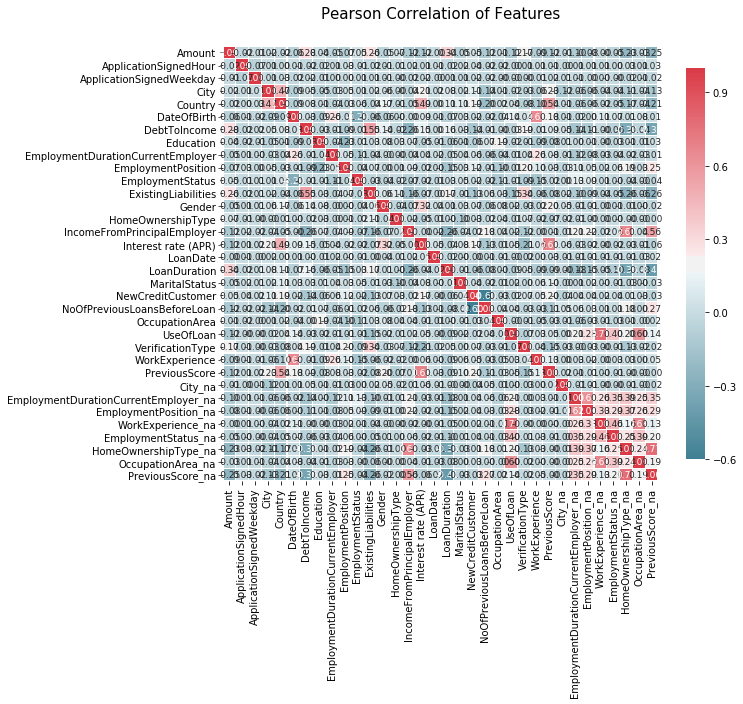

In [49]:
correlationHeatmap(X_train)

In [4]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
corr_features

{'DebtToIncome_na',
 'Education_na',
 'Gender_na',
 'IncomeTotal',
 'MaritalStatus_na',
 'VerificationType_na'}

In [5]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((22333, 34), (5584, 34))

### Model Feature Selection

In [20]:
def run_randomForests(X_train, X_test, y_train, y_test, n_estimators=10, max_depth = 4, max_leaf_nodes = None):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0, max_depth=max_depth, 
                                max_leaf_nodes=max_leaf_nodes)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

**Tune the estimators**

In [22]:
n_estimators = [5, 10, 20, 30]
for est in n_estimators:
    print(est)
    run_randomForests(X_train, X_test, y_train, y_test, n_estimators=est, max_depth = None, max_leaf_nodes = None)
    print()

5
Train set
Random Forests roc-auc: 0.9929548198131335
Test set
Random Forests roc-auc: 0.7299083113027021

10
Train set
Random Forests roc-auc: 0.9993159211588647
Test set
Random Forests roc-auc: 0.7717359207408803

20
Train set
Random Forests roc-auc: 0.9999735369334726
Test set
Random Forests roc-auc: 0.7951605416861397

30
Train set
Random Forests roc-auc: 0.9999990616573751
Test set
Random Forests roc-auc: 0.8027731711088324



**Tune the max_depth**

In [25]:
n_depth = [2, 4, 6, 8]
for depth in n_depth:
    print(depth)
    run_randomForests(X_train, X_test, y_train, y_test, n_estimators=10, max_depth = depth, max_leaf_nodes = None)
    print()

2
Train set
Random Forests roc-auc: 0.726747030659876
Test set
Random Forests roc-auc: 0.7429015155214227

4
Train set
Random Forests roc-auc: 0.7609547035308282
Test set
Random Forests roc-auc: 0.7744449181902098

6
Train set
Random Forests roc-auc: 0.781345854180329
Test set
Random Forests roc-auc: 0.7848357904171985

8
Train set
Random Forests roc-auc: 0.8162724147947905
Test set
Random Forests roc-auc: 0.7948075574947162



### Get the features for model

In [41]:
sel_ = RFE(RandomForestClassifier(n_estimators = 10, max_depth = 6, random_state=0))
sel_.fit(X_train.fillna(0), y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [57]:
selected_feats = X_train.columns[(sel_.get_support())]
pd.Series(selected_feats).to_csv('selected_features.csv', index=False)
print(selected_feats)

Index(['Amount', 'City', 'Country', 'DateOfBirth', 'DebtToIncome', 'Education',
       'EmploymentPosition', 'ExistingLiabilities', 'Gender',
       'HomeOwnershipType', 'IncomeFromPrincipalEmployer',
       'Interest rate (APR)', 'LoanDuration', 'NewCreditCustomer',
       'NoOfPreviousLoansBeforeLoan', 'VerificationType', 'PreviousScore'],
      dtype='object')


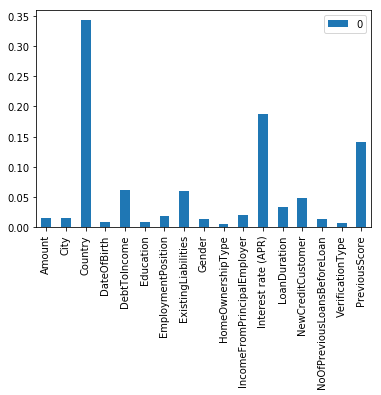

In [78]:
f_imp = pd.Series(sel_.estimator_.feature_importances_, selected_feats).to_frame()
f_imp.plot.bar()
plt.show()